# Basic EDA
In the process of reading the relavant literature I found a very detailed and in depth EDA which gave me a very good idea and know how of the dataset. The object of this EDA is just to get hands-on with the datasets. 

**Note**: The In Depth EDA I read: [
HuBMAP - Exploratory Data Analysis](https://www.kaggle.com/ihelon/hubmap-exploratory-data-analysis) by [@Yaroslav Isaienkov](https://www.kaggle.com/ihelon). Also, the original dataset consisted of TIF files with very large resolution (each file of about 5GB) which was reduced to smaller patches of `1024x1024` (loss less patches) by - [@iafoss](https://www.kaggle.com/iafoss) which was further reduced to `256x256` by [@Wojtek Rosa](https://www.kaggle.com/wrrosa)  as the `1024x1024` was overshotting the memory. So, in the end the work/experiments are done upon [this](https://www.kaggle.com/wrrosa/hubmap-tfrecords-1024-256?select=train2) dataset.

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
gcs_path = 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828'

In [4]:
!gsutil ls {gcs_path}/train/

gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/0486052bb-355.tfrec
gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/095bf7a1f-656.tfrec
gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/1e2425f28-586.tfrec
gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/26dc41664-794.tfrec
gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/2f6ecfcdf-324.tfrec
gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/4ef6695ce-1220.tfrec
gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/54f2eec69-299.tfrec
gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/8242609fa-770.tfrec
gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/aaa6a05cc-134.tfrec
gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/afa5e8098-1125.tfrec
gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/b2dc84

## Looking into a TFRecord

In [29]:
# Just looking at the raw data
raw_dataset = tf.data.TFRecordDataset(gcs_path + '/train/2f6ecfcdf-324.tfrec')

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\335\331\336\336\332\336\335\331\336\335\331\336\335\331\336\336\332\337\335\331\336\336\332\337\336\333\335\336\334\336\335\332\334\336\333\335\335\332\334\336\333\335\336\333\335\336\333\335\337\332\334\340\333\335\337\332\334\340\334\336\336\332\334\337\333\335\340\333\335\337\332\335\340\332\337\337\331\336\337\331\336\337\331\336\340\332\337\337\331\336\340\332\336\340\332\336\340\332\334\340\333\335\340\333\335\337\332\334\336\333\335\335\332\334\335\332\334\335\332\334\335\332\334\335\332\334\336\333\335\336\332\335\337\332\335\336\332\336\336\333\336\334\332\335\335\331\336\336\332\337\336\332\337\336\332\336\337\332\334\336\333\335\337\334\336\335\333\335\335\333\334\336\333\335\336\332\337\335\332\336\336\333\335\336\333\335\335\332\334\337\333\336\335\331\336\336\332\337\336\332\337\336\333\337\335\332\334\335\332\334\335\332\334\337\334\336\336\333\335\336\333\335\336\333\335\337\334\336\

So we have 4 keys and we need the 'image' and 'mask' keys. So lets make a TFRecord parser.

In [37]:
def parser(values):
  feature_foramt = {
      'image' : tf.io.FixedLenFeature([], tf.string),
      'mask'  : tf.io.FixedLenFeature([], tf.string)
  }

  example = tf.io.parse_single_example(values, feature_foramt)
  img = tf.reshape(tf.io.decode_raw(example['image'], out_type=np.dtype('uint8')), (256, 256, 3))
  mask = tf.reshape(tf.io.decode_raw(example['mask'], out_type=np.dtype('uint8')), (256, 256, 1))
  return img, mask

In [38]:
ds = tf.data.TFRecordDataset(gcs_path + '/train/0486052bb-355.tfrec')
ds = ds.map(parser)

In [44]:
sample = None
for i in ds:
  sample = i
  if np.sum(sample[1]) != 0:
    break

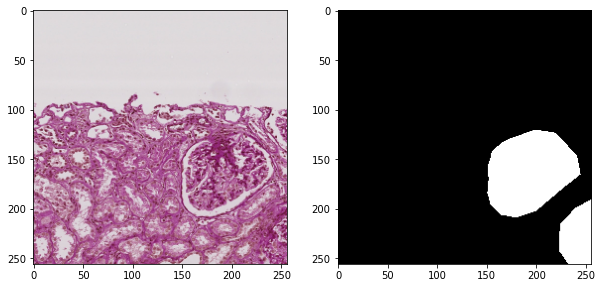

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sample[0])
plt.subplot(1,2,2)
plt.imshow(sample[1][:, :, 0], cmap='gray')